这里采用新的数据，每个点表示15帧的数据，一共22500帧，1500个点

In [1]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA
from matplotlib.collections import LineCollection
import pandas as pd

import scipy.io

In [2]:
# Load original data:

data_470 = pd.read_csv('/Users/haotianli/Documents/MATLAB/behaviorAnalysis/Data_470_longer.csv')
data_555 = pd.read_csv('/Users/haotianli/Documents/MATLAB/behaviorAnalysis/Data_555_longer.csv')

data_470 = data_470.to_numpy()
data_555 = data_555.to_numpy()

data_470_tensor = torch.tensor(data_470)
data_555_tensor = torch.tensor(data_555)
print(f'data_470_tensor.shape:', data_470_tensor.shape)
print(f'data_555_tensor.shape:', data_555_tensor.shape)

data_both_tensor = torch.cat((data_470_tensor, data_555_tensor), dim=1)
print(f'data_both_tensor.shape:', data_both_tensor.shape)

mvData = scipy.io.loadmat('/Users/haotianli/Documents/MATLAB/behaviorAnalysis/originalMovements_longer.mat') # mvData is a Dict
print(f'mvData.keys():', mvData.keys())

originalMovements = mvData['pred1']
originalMovements = torch.tensor(originalMovements)
print(f'originalMovements.shape:', originalMovements.shape)


data_470_tensor.shape: torch.Size([22499, 2])
data_555_tensor.shape: torch.Size([22499, 2])
data_both_tensor.shape: torch.Size([22499, 4])
mvData.keys(): dict_keys(['__header__', '__version__', '__globals__', 'pred1'])
originalMovements.shape: torch.Size([22500, 3, 21])


In [3]:
originalMovements = originalMovements[:, :, :20] # 最后一个点有点奇怪，并不用它
relativeMovements = torch.empty_like(originalMovements)

for i in range(19):
    relativeMovements[:, :, i] = originalMovements[:, :, i] - originalMovements[:, :, 0]

print(f'relativeMovements.shape:', relativeMovements.shape)

recombinedMovements = torch.empty(22486, 3, 20, 2)
for i in range(22486):
    recombinedMovements[i, :, :, 0] = relativeMovements[i+7, :, :]
    recombinedMovements[i, :, :, 1] = originalMovements[i+14, :, :] - originalMovements[i, :, :]
    # 记录0.3s时的相对位置和0.6s内的相对位移(15帧对应0.6s)
    
print(f'recombinedMovements.shape:', recombinedMovements.shape)
print(recombinedMovements[0, :, 0, :])

relativeMovements.shape: torch.Size([22500, 3, 20])
recombinedMovements.shape: torch.Size([22486, 3, 20, 2])
tensor([[  0.0000, -16.8614],
        [  0.0000,   1.4512],
        [  0.0000,   1.4820]])


In [4]:
recombinedData = torch.empty(22486, 60)
for i in range(22485):
    recombinedData[i, :] = torch.cat([data_both_tensor[i, :], data_both_tensor[i+1, :], data_both_tensor[i+2, :],
                                         data_both_tensor[i+3, :], data_both_tensor[i+4, :], data_both_tensor[i+5, :],
                                         data_both_tensor[i+6, :], data_both_tensor[i+7, :], data_both_tensor[i+8, :],
                                         data_both_tensor[i+9, :], data_both_tensor[i+10, :], data_both_tensor[i+11, :],
                                         data_both_tensor[i+12, :], data_both_tensor[i+13, :], data_both_tensor[i+14, :]],
                                         dim=-1)
    
print(f'recombinedMovements.shape:', recombinedData.shape)
print(recombinedData[0, :])

recombinedMovements.shape: torch.Size([22486, 60])
tensor([39.8441, 36.7893, 38.6367, 40.9445, 16.0287, 14.0434, 16.0163, 16.7545,
         2.1001,  0.9872,  2.0704,  1.9473, -5.1776, -4.0253, -6.2187, -6.2606,
        -8.9083, -7.9010, -9.0291, -9.7158, -9.6331, -8.8466, -9.6606, -9.7356,
        -6.9230, -6.3349, -7.7372, -8.0324, -3.2276, -2.7282, -3.9273, -3.9666,
         0.3868,  0.2606,  0.7379,  0.5121,  3.7740,  2.8230,  4.2963,  4.3211,
         4.9848,  4.0378,  5.6070,  6.1124,  5.3284,  5.3009,  6.0405,  6.0154,
         4.4602,  4.7582,  4.6444,  4.7597,  2.0041,  2.1508,  1.7811,  1.9717,
        -0.3508, -0.2718, -0.4680, -0.4411])


In [5]:
max_iterations = 1
output_dimension = 32 # here, we set as a variable for hypothesis testing below.

relativeMovementsIndex = relativeMovements[7:-7]
print(relativeMovementsIndex.shape)
print(relativeMovements[1, :, :])

relativeMovementsIndex = relativeMovementsIndex.reshape(22486, -1)
print(relativeMovementsIndex.shape)

torch.Size([22486, 3, 20])
tensor([[  0.0000,  11.4123,  18.8121,   0.6629, -25.8259, -39.2717, -57.7071,
          -5.2035,  -6.8539, -11.6417,  -6.2767,   1.8661,   1.1683,   0.3176,
           3.5627, -34.2396, -36.4796, -29.9723, -21.7945,   0.0000],
        [  0.0000, -23.6484,  -2.5210, -14.1014, -32.9555, -48.1860, -58.0846,
          -7.3255,  -9.6916, -10.7005,  -9.0297, -22.1142, -23.9138, -24.0226,
         -22.3292, -25.1588, -32.6603, -26.9502, -52.3170,   0.0000],
        [  0.0000,  -1.3511, -23.4172,  -6.9699,  -4.3073, -12.8837, -11.4286,
         -24.4257, -21.8923, -14.2840,  -6.6927, -27.7108, -26.5971, -17.5156,
          -7.6515, -27.4081, -22.9548, -15.4427, -23.2661,   0.0000]],
       dtype=torch.float64)
torch.Size([22486, 60])


In [6]:
cebra_dr_both_behavior = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dr_both_behavior.fit(recombinedData, relativeMovementsIndex)
cebra_dr_both_behavior_para = cebra_dr_both_behavior.transform(recombinedData)

pos: -0.6308 neg:  6.7807 total:  6.1500 temperature:  1.0000: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


In [7]:
cebra_dr_both_time_behavior = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid = True)

cebra_dr_both_time_behavior.fit(recombinedData, relativeMovementsIndex)
cebra_dr_both_time_behavior_para = cebra_dr_both_time_behavior.transform(recombinedData)

behavior_pos: -0.6900 behavior_neg:  6.8516 behavior_total:  6.1616 time_pos: -0.5720 time_neg:  6.8516 time_total:  6.2796: 100%|██████████| 1/1 [00:00<00:00, 17.66it/s]


In [8]:
cebra_dr_both_time_behavior_shuffle = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

### Shuffle the behavior variable and use it for training
shuffled_posdir = np.random.permutation(relativeMovementsIndex)
cebra_dr_both_time_behavior_shuffle.fit(recombinedData, shuffled_posdir)
cebra_dr_both_time_behavior_shuffle_para = cebra_dr_both_time_behavior_shuffle.transform(recombinedData)

pos: -0.4579 neg:  6.7632 total:  6.3053 temperature:  1.0000: 100%|██████████| 1/1 [00:00<00:00, 59.40it/s]


In [9]:
cebra_dr_both_time = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.12,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dr_both_time.fit(recombinedData)
cebra_dr_both_time_para = cebra_dr_both_time.transform(recombinedData)

pos: -0.5707 neg:  6.8038 total:  6.2331 temperature:  1.1200: 100%|██████████| 1/1 [00:00<00:00, 55.27it/s]


In [10]:
def plot_cebra_both(ax, embedding, label, gray = False, idx_order = (0,1,2)):
    r_ind = torch.ones(label.size(0), dtype=torch.bool)
    print(r_ind)
    l_ind = 0 # 这里假设所有点都满足r标签为真(目前的系统不需要考虑左右标签，可以降维结束后另外更改作图条件)

    if not gray:
        r_cmap = 'cool'
        l_cmap = 'viridis'
        r_c = label[r_ind, 0]
        l_c = label[l_ind, 0]
    else:
        r_cmap = None
        l_cmap = None
        r_c = 'gray'
        l_c = 'gray'

    idx1, idx2, idx3 = idx_order
    
    r=ax.scatter(embedding [r_ind,idx1], # 只启用这里的scatter,产生的是假颜色
               embedding [r_ind,idx2],
               embedding [r_ind,idx3],
               c=r_c,
               cmap=r_cmap, s=0.2)
    l=ax.scatter(embedding [l_ind,idx1],
               embedding [l_ind,idx2],
               embedding [l_ind,idx3],
               c=l_c,
               cmap=l_cmap, s=0.2)

    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    return ax

tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])
tensor([True, True, True,  ..., True, True, True])


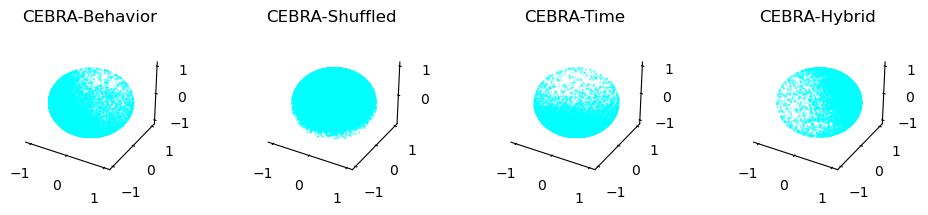

In [11]:
%matplotlib inline
fig = plt.figure(figsize=(10,2))

ax1 = plt.subplot(141, projection='3d')
ax2 = plt.subplot(142, projection='3d')
ax3 = plt.subplot(143, projection='3d')
ax4 = plt.subplot(144, projection='3d')

ax1=plot_cebra_both(ax1, cebra_dr_both_behavior_para, relativeMovementsIndex)
ax2=plot_cebra_both(ax2, cebra_dr_both_time_behavior_shuffle_para, relativeMovementsIndex)
ax3=plot_cebra_both(ax3, cebra_dr_both_time_para, relativeMovementsIndex)
ax4=plot_cebra_both(ax4, cebra_dr_both_time_behavior_para, relativeMovementsIndex)

ax1.set_title('CEBRA-Behavior')
ax2.set_title('CEBRA-Shuffled')
ax3.set_title('CEBRA-Time')
ax4.set_title('CEBRA-Hybrid')
plt.tight_layout()
plt.show()